# How Do Weather Conditions Impact Electricity Consumption?

In this notebook, we use a dataset (previously used in an Analytics Vidhya hackathon that is now closed) to predict electricity consumption in the fictitious country of Electrovania, on an hourly basis based upon factors related to the weather.

## Import Packages

In [1]:
# Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Timing modules
import datetime as dt
import time
# Machine Learning
from sklearn.neighbors import KernelDensity

## Exploratory Data Analysis

### Reading in the Data

Training and testing data were initially split into different CSV files as part of Analytics Vidhya's hackathon. For this analysis however, I will be rejoining them and randomly splitting them using Scikit-learn, in order to introduce more "randomness" into the experiments.

In [2]:
# two separate DataFrames
df1 = pd.read_csv('Electricity_Consumption/train.csv')
df2 = pd.read_csv('Electricity_Consumption/test.csv')

In [3]:
df1.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [4]:
df2.tail()

,ID,datetime,temperature,var1,pressure,windspeed,var2
8563,35059,2017-06-30 19:00:00,-5.7,-18.6,998.0,233.595,A
8564,35060,2017-06-30 20:00:00,-5.7,-17.1,995.0,238.780,A
8565,35061,2017-06-30 21:00:00,-7.1,-19.3,1004.0,244.325,A
8566,35062,2017-06-30 22:00:00,-6.4,-19.3,1008.0,247.470,A
8567,35063,2017-06-30 23:00:00,-5.0,-16.4,1001.0,250.600,A


In [5]:
# target variable is electricity_consumption
target = 'electricity_consumption'

### Combining DataFrames into One

From the above, we can see that: 

- both DataFrames have exactly the same features
- and that the samples are unique
- HOWEVER, the testing DataFrame is lacks a column for the 'electricity_consumption' - our target variable!

Therefore, we want to merely append one of the DataFrames to the other - this looks best-suited for an "outer" merge in pandas!

In [6]:
# Merge the DataFrames
df = pd.merge(df1, df2, how='outer')
# see if the head matches the head of df1
df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [7]:
# AND, check to see if the bottom of the new df == bottom of df2!
df.tail()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
35059,35059,2017-06-30 19:00:00,-5.7,-18.6,998.0,233.595,A,NaN
35060,35060,2017-06-30 20:00:00,-5.7,-17.1,995.0,238.780,A,NaN
35061,35061,2017-06-30 21:00:00,-7.1,-19.3,1004.0,244.325,A,NaN
35062,35062,2017-06-30 22:00:00,-6.4,-19.3,1008.0,247.470,A,NaN
35063,35063,2017-06-30 23:00:00,-5.0,-16.4,1001.0,250.600,A,NaN


### Removing Columns

The 'ID', 'var1', and 'var2' came with no description so they don't necessarily carry any useful information. Therefore I will be dropping them.

In [8]:
df = df.drop(columns=['ID', 'var1', 'var2'])

### Filling in NaN values

The samples in the previously labeled 'testing' data must have values for electricity_consumption, otherwise we won't be able to gauge how accurate the model's predicted value is to the "actual" value. This is because we are doing regression, a form of **supervised learning**.

A proposed method of finding reasonable values to fill in the Nan's is to use a Kernel Density Estimation.

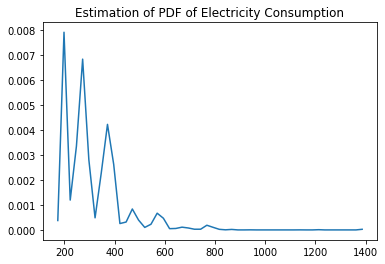

In [9]:
# Let's estimate the probability density function of the values we have so far for 'electricity_consumption'
# then, we can estimate new values for the column!

kde = KernelDensity(kernel='gaussian', bandwidth=0.6)
target = np.array(df[target].iloc[0:26496])
kde.fit(target.reshape(-1,1))

s = np.linspace(np.min(target), np.max(target))
log_pdf = kde.score_samples(s.reshape(-1,1))
plt.plot(s, np.exp(log_pdf))
plt.title('Estimation of PDF of Electricity Consumption')
plt.show()

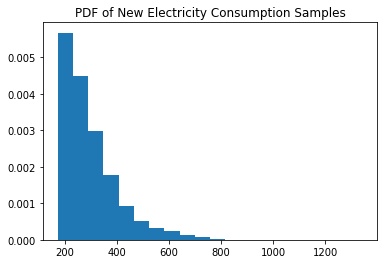

In [10]:
# Now, let's generate samples for the electricity consumption in df2
num_samples_needed = len(df2['ID'])
guesses = kde.sample(num_samples_needed)
# Plot the distribution of the samples
plt.hist(guesses, bins=20, density=1)
plt.title('PDF of New Electricity Consumption Samples')
plt.show()

In [11]:
# add to the Dataframe2 
df2['electricity_consumption'] = guesses
# remake the combined DataFrame again
df = pd.merge(df1, df2, how='outer')

In [12]:
# re-drop the useless columns
df = df.drop(columns=['ID', 'var1', 'var2'])

### Categorizing Datetime Values

In order for the datetime column to be of use to the model, it needs to be converted to a numerical data type. In fact, **the datetime column is best suited to becoming categorical data**. Since we already have features for the temperature, pressure, and windspeed,**we don't need the datetime to tell us the time of year**. However, **it can tell us the time of day**, because that can also affect electricity consumption.

Therefore, I will categorize the values based upon the following:

- 04:00-12:00: 'morning'
- 13:00-22:00: 'afternoon'
- 23:00-03:00: 'evening'

In [14]:
dates = df['datetime']
dates

0        2013-07-01 00:00:00
1        2013-07-01 01:00:00
2        2013-07-01 02:00:00
3        2013-07-01 03:00:00
4        2013-07-01 04:00:00
                ...         
35059    2017-06-30 19:00:00
35060    2017-06-30 20:00:00
35061    2017-06-30 21:00:00
35062    2017-06-30 22:00:00
35063    2017-06-30 23:00:00
Name: datetime, Length: 35064, dtype: object